# Machine Learning

In [1]:
# Manipulação de Dados
import pandas as pd
import numpy as np
from datetime import datetime
import time
import os

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Matemática e Estatística
from math import sqrt
from scipy.stats import skew
from scipy import stats

# Avaliação dos Modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

# Avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
from Modulos.CLASSE_Resultados_Modelos import Resultados_Modelos
from Modulos.FUNCAO_Scores_Grid import grid_scores
from Modulos.FUNCAO_Plot_Validacao import plot_validacao

#### Carregamento dos dados

In [3]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']

nomes_csv = ['X_test', 'X_train', 'y_test', 'y_train']
for file, nome in zip(files_csv, nomes_csv):
    exec(f'{nome} = pd.read_csv("{file}")')

### Iniciando a etapa de busca pelo melhor modelo

#### Modelo 1 - Regressão Linear

In [4]:
# Estimando o modelo e fazendo previsões
modelo_v1 = LinearRegression(fit_intercept = True).fit(X_train, y_train)
previsao_v1 = modelo_v1.predict(X_test)

# Salvando os resultados e apresentando
Resultados1 = Resultados_Modelos(y_test, previsao_v1, 'Regressão Linear')
Resultados1.resultados_todos_modelos

,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%


#### Plot de Validação

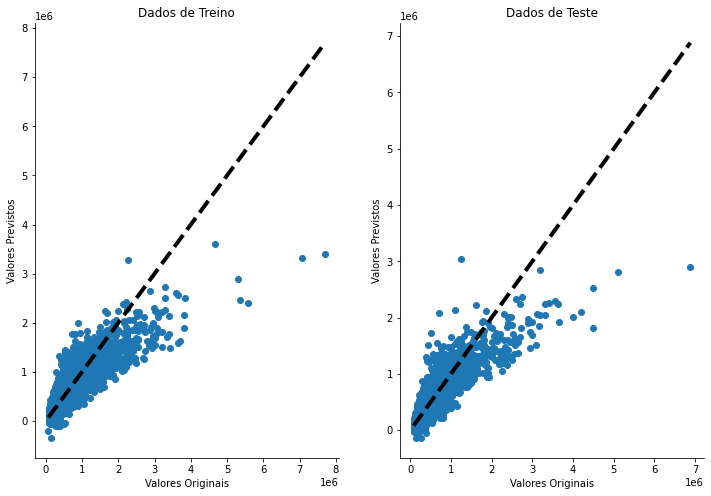

In [25]:
plot_validacao(y_train, y_test, modelo_v1.predict(X_train), previsao_v1)

#### Modelo 2 - Random Forest

In [5]:
%%time

# Parâmetros
criterio = ['squared_error']
estimacoes = [100, 500, 1000]
max_dep = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# GridSearchCV
gridCV_modelo2 = GridSearchCV(estimator = RandomForestRegressor(random_state = 8),
                              param_grid = {'criterion' : criterio, 'n_estimators' : estimacoes, 'max_depth' : max_dep},
                              n_jobs = -1, cv = 3, refit = 'neg_mean_squared_error',
                              scoring = ['neg_mean_squared_error',
                                         'neg_mean_absolute_error', 'r2']).fit(X_train, y_train)

Wall time: 1min 19s


In [6]:
grid_scores(gridCV_modelo2, 'Random Forest Regressor')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: Random Forest Regressor
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'criterion': 'squared_error', 'max_depth': 19, 'n_estimators': 500}
--------------------------------------------------------------------------------
Resultados da métrica de MSE:

Média de MSE é: -7035818765.6209
Desvio-padrão de MSE é: 887880319.2164
--------------------------------------------------------------------------------
Resultados da métrica de MAE:

Média de MAE é: -26980.1111
Desvio-padrão de MAE é: 271.3544
--------------------------------------------------------------------------------
Resultados da métrica de R2:

Média de R2 é: 0.9469
Desvio-padrão do R2 é: 0.0063


#### Estimando o melhor modelo

In [7]:
%%time

# Estimando o modelo e fazendo previsões
modelo_v2 = RandomForestRegressor(**gridCV_modelo2.best_params_,
                                  n_jobs = -1, random_state = 8).fit(X_train, y_train)
previsao_v2 = modelo_v2.predict(X_test)

# Salvando os resultados e apresentando
Resultados2 = Resultados_Modelos(y_test, previsao_v2, 'Random Forest Regressor')
Resultados2.resultados_todos_modelos

Wall time: 5.29 s


,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%


#### Plot de Validação

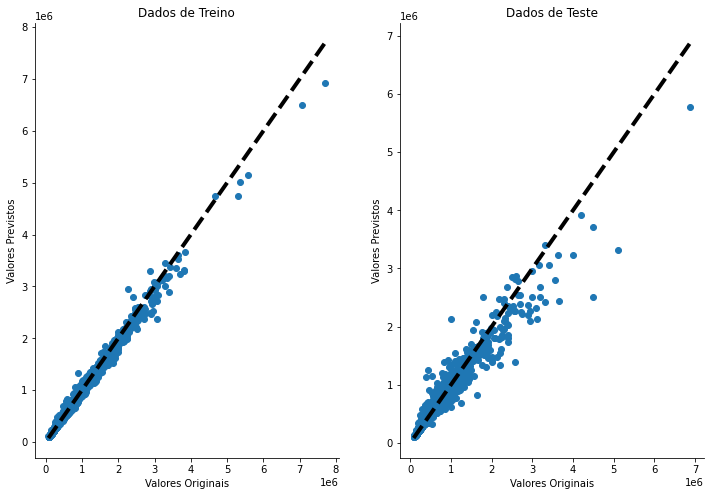

In [9]:
plot_validacao(y_train, y_test, modelo_v2.predict(X_train), previsao_v2)

#### Modelo 2.1 - Random Forest com Seleção de Variáveis

#### Variáveis mais relevantes

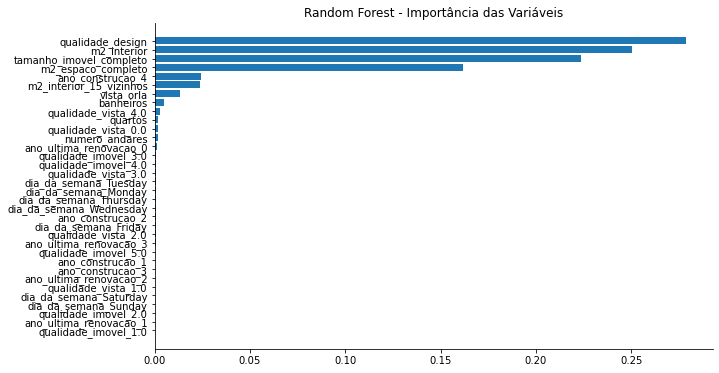

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))
rearrumando = modelo_v2.feature_importances_.argsort()
plt.barh(modelo_v2.feature_names_in_[rearrumando], modelo_v2.feature_importances_[rearrumando])
plt.title('Random Forest - Importância das Variáveis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();

In [11]:
# Obtendo as 12 variáveis mais relevantes
index_selecionadas = modelo_v2.feature_importances_.argsort()[::-1][0:12]
variaveis_selecionadas = modelo_v2.feature_names_in_[index_selecionadas]

# Novo dataframe com variaveis selecionadas
X_train_selecao = X_train[variaveis_selecionadas]
X_test_selecao = X_test[variaveis_selecionadas]

#### Etapa GridSearchCV

In [14]:
%%time

# Parâmetros
criterio = ['squared_error']
estimacoes = [50, 100, 500, 1000]
max_dep = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# GridSearchCV
gridCV_modelo2_1 = GridSearchCV(estimator = RandomForestRegressor(random_state = 8),
                              param_grid = {'criterion' : criterio, 'n_estimators' : estimacoes, 'max_depth' : max_dep},
                              n_jobs = -1, cv = 3, refit = 'neg_mean_squared_error',
                              scoring = ['neg_mean_squared_error',
                                         'neg_mean_absolute_error', 'r2']).fit(X_train_selecao, y_train)

Wall time: 57.1 s


In [15]:
grid_scores(gridCV_modelo2_1, 'Random Forest Regressor - Seleção de Variáveis')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: Random Forest Regressor - Seleção de Variáveis
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'criterion': 'squared_error', 'max_depth': 19, 'n_estimators': 500}
--------------------------------------------------------------------------------
Resultados da métrica de MSE:

Média de MSE é: -6451733990.6551
Desvio-padrão de MSE é: 842083314.0525
--------------------------------------------------------------------------------
Resultados da métrica de MAE:

Média de MAE é: -25729.4036
Desvio-padrão de MAE é: 231.3535
--------------------------------------------------------------------------------
Resultados da métrica de R2:

Média de R2 é: 0.9513
Desvio-padrão do R2 é: 0.006


#### Estimando o melhor modelo

In [16]:
%%time

# Estimando o modelo e fazendo previsões
modelo_v2_1 = RandomForestRegressor(**gridCV_modelo2_1.best_params_,
                                    n_jobs = -1, random_state = 8).fit(X_train_selecao, y_train)
previsao_v2_1 = modelo_v2_1.predict(X_test_selecao)

# Salvando os resultados e apresentando
Resultados2_1 = Resultados_Modelos(y_test, previsao_v2_1, 'Random Forest Regressor - Seleção de Variáveis')
Resultados2_1.resultados_todos_modelos

Wall time: 3.29 s


,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%
2,Random Forest Regressor - Seleção de Variáveis,81176.6994,23284.4146,0.9531,3.17%


#### Plot de Validação

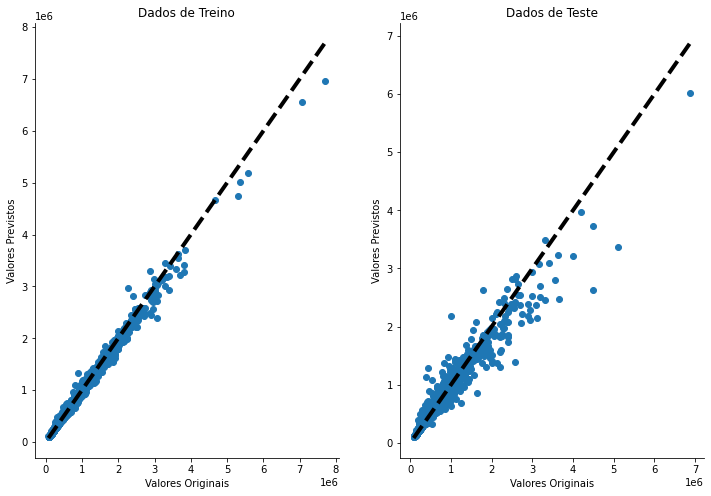

In [17]:
plot_validacao(y_train, y_test, modelo_v2_1.predict(X_train_selecao), previsao_v2_1)

#### Modelo 3 - XGBoost

In [18]:
%%time

# Parâmetros
learning = [0.01, 0.1]
max_dep = [3, 6, 9, 12]
scale_weight = [1, 5]
estimadores = [500, 750, 1000, 1500]

# GridSearchCV
gridCV_modelo3 = GridSearchCV(estimator = XGBRegressor(random_state = 8),
                              param_grid = {'learning_rate' : learning, 'max_depth' : max_dep,
                                            'scale_pos_weight' : scale_weight, 'n_estimators' : estimadores},
                              n_jobs = -1, cv = 3, refit = 'neg_mean_squared_error',
                              scoring = ['neg_mean_squared_error',
                                         'neg_mean_absolute_error', 'r2']).fit(X_train_selecao,
                                                                               y_train,
                                                                               verbose = False,
                                                                               early_stopping_rounds = 5,
                                                                               eval_set = [(X_test_selecao, y_test)])

Wall time: 44.1 s


In [19]:
grid_scores(gridCV_modelo3, 'XGBoost Regressor - Seleção de Variáveis')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: XGBoost Regressor - Seleção de Variáveis
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 1}
--------------------------------------------------------------------------------
Resultados da métrica de MSE:

Média de MSE é: -3506279905.1409
Desvio-padrão de MSE é: 693253113.0369
--------------------------------------------------------------------------------
Resultados da métrica de MAE:

Média de MAE é: -24700.8604
Desvio-padrão de MAE é: 350.9023
--------------------------------------------------------------------------------
Resultados da métrica de R2:

Média de R2 é: 0.9735
Desvio-padrão do R2 é: 0.0051


#### Estimando o melhor modelo

In [20]:
%%time

# Estimando o modelo e fazendo previsões
modelo_v3 = XGBRegressor(**gridCV_modelo3.best_params_,
                           n_jobs = -1,
                           random_state = 8).fit(X_train_selecao, y_train)
previsao_v3 = modelo_v3.predict(X_test_selecao)

# Salvando os resultados e apresentando
Resultados3 = Resultados_Modelos(y_test, previsao_v3, 'XGBoost Regressor - Seleção de Variáveis')
Resultados3.resultados_todos_modelos

Wall time: 1.09 s


,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%
2,Random Forest Regressor - Seleção de Variáveis,81176.6994,23284.4146,0.9531,3.17%
3,XGBoost Regressor - Seleção de Variáveis,49559.0536,22832.4243,0.9825,4.0%


#### Plot de Validação

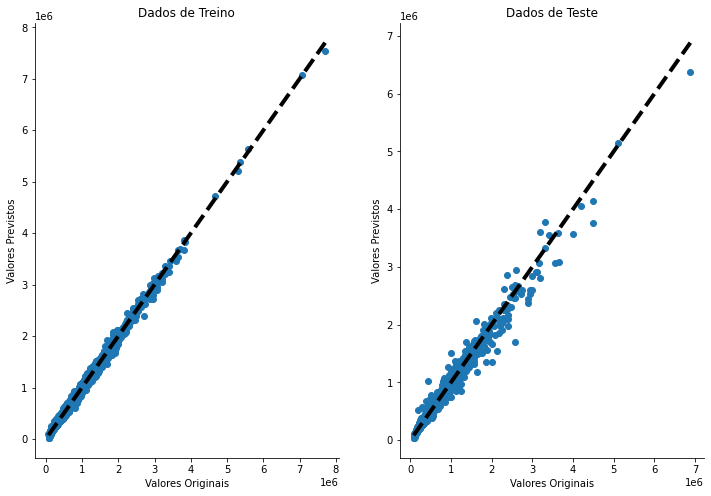

In [21]:
plot_validacao(y_train, y_test, modelo_v3.predict(X_train_selecao), previsao_v3)

#### Modelo 4 - CatBoost

In [22]:
%%time

# Parâmetros
learning = [0.01, 0.1]
max_dep = [3, 6, 9, 12]
estimadores = [500, 750, 1000, 1500]

# GridSearchCV
gridCV_modelo4 = GridSearchCV(estimator = CatBoostRegressor(random_state = 8,
                                                            thread_count = 12,
                                                            verbose = False,
                                                           loss_function = 'RMSE'),
                              param_grid = {'learning_rate' : learning, 'max_depth' : max_dep,
                                            'n_estimators' : estimadores},
                              n_jobs = -1, cv = 3, refit = 'neg_mean_squared_error',
                              scoring = ['neg_mean_squared_error',
                                         'neg_mean_absolute_error', 'r2']).fit(X_train_selecao,
                                                                               y_train,
                                                                               early_stopping_rounds = 5,
                                                                               eval_set = [(X_test_selecao, y_test)])

Wall time: 1min 30s


In [23]:
grid_scores(gridCV_modelo4, 'CatBoost Regressor - Seleção de Variáveis')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: CatBoost Regressor - Seleção de Variáveis
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
--------------------------------------------------------------------------------
Resultados da métrica de MSE:

Média de MSE é: -2884672101.2692
Desvio-padrão de MSE é: 725958137.1007
--------------------------------------------------------------------------------
Resultados da métrica de MAE:

Média de MAE é: -17786.6091
Desvio-padrão de MAE é: 116.373
--------------------------------------------------------------------------------
Resultados da métrica de R2:

Média de R2 é: 0.9783
Desvio-padrão do R2 é: 0.0052


#### Estimando o melhor modelo

In [24]:
%%time

# Estimando o modelo e fazendo previsões
modelo_v4 = CatBoostRegressor(**gridCV_modelo4.best_params_,
                              thread_count = -1,
                              verbose = False,
                              loss_function = 'RMSE',
                              random_state = 8).fit(X_train_selecao, y_train)
previsao_v4 = modelo_v4.predict(X_test_selecao)

# Salvando os resultados e apresentando
Resultados4 = Resultados_Modelos(y_test, previsao_v4, 'CatBoost Regressor - Seleção de Variáveis')
Resultados4.resultados_todos_modelos

Wall time: 1.28 s


,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%
2,Random Forest Regressor - Seleção de Variáveis,81176.6994,23284.4146,0.9531,3.17%
3,XGBoost Regressor - Seleção de Variáveis,49559.0536,22832.4243,0.9825,4.0%
4,CatBoost Regressor - Seleção de Variáveis,39085.3608,16360.6011,0.9891,2.84%


#### Plot de Validação

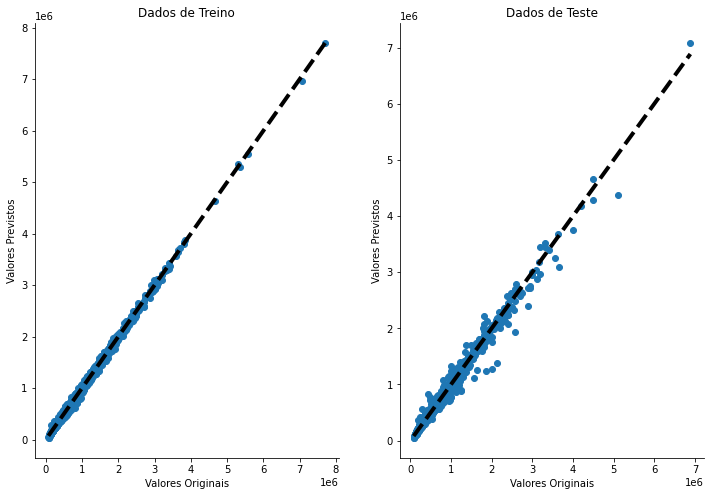

In [26]:
plot_validacao(y_train, y_test, modelo_v4.predict(X_train_selecao), previsao_v4)

#### Modelo 5 - LightGBM

In [27]:
%%time

# Parâmetros
learning = [0.01, 0.1]
max_dep = [3, 6, 9, 12]
estimadores = [500, 750, 1000, 1500]
boosting = ['gbdt', 'rf', 'dart', 'goss']


# GridSearchCV
gridCV_modelo5 = GridSearchCV(estimator = lgb.LGBMRegressor(random_state = 8),
                              param_grid = {'learning_rate' : learning, 'max_depth' : max_dep,
                                            'n_estimators' : estimadores,
                                            'boosting' : boosting},
                              n_jobs = -1, cv = 3, refit = 'neg_mean_squared_error',
                              scoring = ['neg_mean_squared_error',
                                         'neg_mean_absolute_error', 'r2']).fit(X_train_selecao,
                                                                               y_train,
                                                                               verbose = False,
                                                                               early_stopping_rounds = 5,
                                                                               eval_set = [(X_test_selecao, y_test)])

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Wall time: 3.86 s


In [28]:
grid_scores(gridCV_modelo5, 'LightGBM - Seleção de Variáveis')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: LightGBM - Seleção de Variáveis
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
--------------------------------------------------------------------------------
Resultados da métrica de MSE:

Média de MSE é: -3326744620.9104
Desvio-padrão de MSE é: 285813910.0231
--------------------------------------------------------------------------------
Resultados da métrica de MAE:

Média de MAE é: -25284.1132
Desvio-padrão de MAE é: 422.4237
--------------------------------------------------------------------------------
Resultados da métrica de R2:

Média de R2 é: 0.9749
Desvio-padrão do R2 é: 0.0021


#### Estimando o melhor modelo

In [29]:
%%time

# Estimando o modelo e fazendo previsões
modelo_v5 = lgb.LGBMRegressor(**gridCV_modelo5.best_params_,
                           n_jobs = -1,
                           random_state = 8).fit(X_train_selecao, y_train)
previsao_v5 = modelo_v5.predict(X_test_selecao)

# Salvando os resultados e apresentando
Resultados5 = Resultados_Modelos(y_test, previsao_v5, 'LightGBM - Seleção de Variáveis')
Resultados5.resultados_todos_modelos

Wall time: 162 ms


,Algoritmo,RMSE,MAE,R2,MAPE
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%
2,Random Forest Regressor - Seleção de Variáveis,81176.6994,23284.4146,0.9531,3.17%
3,XGBoost Regressor - Seleção de Variáveis,49559.0536,22832.4243,0.9825,4.0%
4,CatBoost Regressor - Seleção de Variáveis,39085.3608,16360.6011,0.9891,2.84%
5,LightGBM - Seleção de Variáveis,54786.7634,24822.1029,0.9786,4.28%


#### Plot de Validação

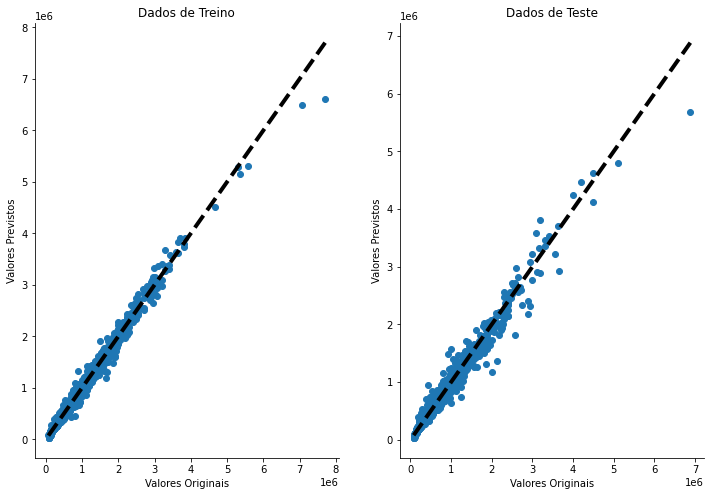

In [30]:
plot_validacao(y_train, y_test, modelo_v5.predict(X_train_selecao), previsao_v5)

### Conclusão

O modelo que apresentou a melhor performance foi o CatBoost. Ao mesmo tempo que apresentou os melhores valores nas métricas avaliadas, o gráfico de validação também apresentou o melhor aspecto. Os valores em teste ficaram muito próximos da linha de 45 graus que determina o ajuste do modelo e entre os gráficos de validação, foi o que visualmente apresenta menor dispersão em comparação a linha de ajuste.

In [32]:
Resultados5.resultados_todos_modelos.sort_values(by = 'MAE', ascending = True)

,Algoritmo,RMSE,MAE,R2,MAPE
4,CatBoost Regressor - Seleção de Variáveis,39085.3608,16360.6011,0.9891,2.84%
3,XGBoost Regressor - Seleção de Variáveis,49559.0536,22832.4243,0.9825,4.0%
2,Random Forest Regressor - Seleção de Variáveis,81176.6994,23284.4146,0.9531,3.17%
1,Random Forest Regressor,83248.2039,24212.4501,0.9506,3.31%
5,LightGBM - Seleção de Variáveis,54786.7634,24822.1029,0.9786,4.28%
0,Regressão Linear,204858.1591,127414.5704,0.7011,25.85%
